# Single Aspect Modelling

In [20]:
'''
Import required packages and libraries for multi-aspect modelling
'''
import joblib
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

In [42]:
PATH = "../cleaning/single_aspect.pkl"

data    = joblib.load(PATH)
matrix  = data["matrix"]
columns = data["columns"]

In [43]:
first_row_coo = matrix[0].tocoo()
for i, v in zip(first_row_coo.col, first_row_coo.data):
    print(f"Column: {columns[i]}, Value: {v}, Column Index: {i}")

Column: Score, Value: 1.0, Column Index: 1


## Training Testing Split

In [56]:
# Target variable we are trying to predict
target_col = columns.index("Score")

x = matrix[:, [i for i in range(matrix.shape[1]) if i != target_col]]   # Remove target variable from sparse matrix
y = matrix[:,columns.index("Score")].toarray().ravel() - 1              # Target variable extracted from sparse matrix

In [57]:
# Check dimensions of model inputs and labels
print(matrix.shape)
print(x.shape)
print(type(y))
print(np.shape(y))

(104247, 35515)
(104247, 35514)
<class 'numpy.ndarray'>
(104247,)


In [58]:
x_train, x_test, y_train, y_test = train_test_split(
    x,              # Sparse matrix
    y,              # Target column
    test_size=0.2,  # 20% test split
    random_state=42
)

## Neural Network Regressor

In [59]:
import tensorflow as tf
from scipy.sparse import csr_matrix, hstack
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.losses import SparseCategoricalCrossentropy, MeanSquaredError

In [71]:
input_dim   = x.shape[1]

n_neurons_1 = 70
n_neurons_2 = 70
n_neurons_3 = 70

output_dim  = 1

epoch_no    = 100
batch_size  = 512

In [72]:
# Define generator for training data
def train_generator():
    for i in range(x_train.shape[0]):
        yield x_train[i].toarray()[0].astype(np.float32), y_train[i]

# Define generator for testing data
def test_generator():
    for i in range(x_test.shape[0]):
        yield x_test[i].toarray()[0].astype(np.float32), y_test[i]

In [73]:
# TensorFlow Datasets from generators
train_dataset = tf.data.Dataset.from_generator(
    train_generator,
    output_signature=(
        tf.TensorSpec(shape=(x_train.shape[1],), dtype=tf.float32),
        tf.TensorSpec(shape=(), dtype=tf.int64),
    )
).batch(batch_size).prefetch(tf.data.AUTOTUNE)

test_dataset = tf.data.Dataset.from_generator(
    test_generator,
    output_signature=(
        tf.TensorSpec(shape=(x_test.shape[1],), dtype=tf.float32),
        tf.TensorSpec(shape=(), dtype=tf.int64),
    )
).batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [74]:
# Add layers and activation function to neural network
nn_reg    = tf.keras.Sequential()

nn_reg.add(Input(shape=(input_dim,)))
nn_reg.add(Dense(n_neurons_1, activation='relu'))
nn_reg.add(Dense(n_neurons_2, activation='relu'))
nn_reg.add(Dense(n_neurons_3, activation='relu'))
nn_reg.add(Dense(output_dim, activation='linear'))

# Configure loss function, gradient descent, and evaluation metrics
nn_reg.compile(
    optimizer=Adam(learning_rate=0.001),
    loss=MeanSquaredError(),
    metrics=["mae"]
)

In [75]:
reg_loss = nn_reg.fit(train_dataset, epochs=epoch_no)

Epoch 1/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 65s 382ms/step - loss: 448.2988 - mae: 8.4778
Epoch 2/100


c:\Users\Cyrus\anaconda3\envs\tfenv\lib\site-packages\keras\src\trainers\epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


163/163 ━━━━━━━━━━━━━━━━━━━━ 63s 385ms/step - loss: 11.5178 - mae: 2.2290
Epoch 3/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 68s 416ms/step - loss: 4.0438 - mae: 1.6709
Epoch 4/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 72s 441ms/step - loss: 3.5396 - mae: 1.5636
Epoch 5/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 62s 382ms/step - loss: 3.2949 - mae: 1.5202
Epoch 6/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 68s 415ms/step - loss: 3.1481 - mae: 1.4592
Epoch 7/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 60s 371ms/step - loss: 2.8614 - mae: 1.4125
Epoch 8/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 58s 357ms/step - loss: 2.6240 - mae: 1.3709
Epoch 9/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 58s 353ms/step - loss: 2.3320 - mae: 1.2789
Epoch 10/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 49s 298ms/step - loss: 2.5611 - mae: 1.3030
Epoch 11/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 47s 285ms/step - loss: 2.0264 - mae: 1.1794
Epoch 12/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 47s 291ms/step - loss: 1.9754 - mae: 1.1503
Epoch 13/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 61s 376ms/step - loss: 2.1065 -

In [60]:
input_dim   = x.shape[1]

n_neurons_1 = 70
n_neurons_2 = 70
n_neurons_3 = 70

output_dim  = 5

epoch_no    = 100
batch_size  = 512

In [61]:
# Add layers and activation function to neural network
nn_class    = tf.keras.Sequential()

nn_class.add(Input(shape=(input_dim,)))
nn_class.add(Dense(n_neurons_1, activation='relu'))
nn_class.add(Dense(n_neurons_2, activation='relu'))
nn_class.add(Dense(n_neurons_3, activation='relu'))
nn_class.add(Dense(output_dim, activation='softmax'))

# Configure loss function, gradient descent, and evaluation metrics
nn_class.compile(
    optimizer=Adam(learning_rate=0.001),
    loss=SparseCategoricalCrossentropy(),
    metrics=["accuracy"]
)

In [ ]:
history = nn_class.fit(train_dataset, epochs=epoch_no)

Epoch 1/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 41s 243ms/step - accuracy: 0.4752 - loss: 16.4879
Epoch 2/100


c:\Users\Cyrus\anaconda3\envs\tfenv\lib\site-packages\keras\src\trainers\epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


163/163 ━━━━━━━━━━━━━━━━━━━━ 39s 241ms/step - accuracy: 0.5777 - loss: 1.8364
Epoch 3/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 39s 237ms/step - accuracy: 0.6112 - loss: 1.7738
Epoch 4/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 38s 233ms/step - accuracy: 0.5988 - loss: 1.7056
Epoch 5/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 38s 231ms/step - accuracy: 0.6616 - loss: 1.1531
Epoch 6/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 37s 226ms/step - accuracy: 0.6387 - loss: 1.2407
Epoch 7/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 41s 252ms/step - accuracy: 0.6574 - loss: 1.1619
Epoch 8/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 51s 310ms/step - accuracy: 0.6581 - loss: 1.1422
Epoch 9/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 47s 288ms/step - accuracy: 0.6615 - loss: 1.1126
Epoch 10/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 47s 290ms/step - accuracy: 0.6400 - loss: 1.3648
Epoch 11/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 48s 293ms/step - accuracy: 0.6454 - loss: 1.2932
Epoch 12/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 44s 272ms/step - accuracy: 0.6614 - loss: 1.1110
Epoch 13/100
163/16

## Modelling

In [68]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [11]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

ridge = Ridge(alpha=1.0)  # You can tune alpha later
ridge.fit(x_train, y_train)
y_pred = ridge.predict(x_test)

mse = mean_squared_error(y_test, y_pred)
print(f"MSE: {mse:.4f}")

aspect_names = columns  # or provide aspect column names directly
coefficients = ridge.coef_

# Get top contributing aspects
top_positive = sorted(zip(coefficients, aspect_names), reverse=True)[:10]
top_negative = sorted(zip(coefficients, aspect_names))[:10]

print("Top Positive Aspects:")
for coef, name in top_positive:
    print(f"{name}: {coef:.4f}")

print("\nTop Negative Aspects:")
for coef, name in top_negative:
    print(f"{name}: {coef:.4f}")

MSE: 1.8369
Top Positive Aspects:
stella: 0.6505
wax lip: 0.5613
extra virgin oil: 0.5585
cloth: 0.5412
fb: 0.5218
chardonnay: 0.5185
molassis flavor: 0.5167
bean puree: 0.4980
iphone: 0.4963
glass ball: 0.4803

Top Negative Aspects:
cupcake frosting: -1.5892
banana yogurt: -1.5159
engine: -1.3183
macaroni cheese: -1.2761
chinese roast: -1.2754
liqueur candy: -1.2748
price wt value: -1.2746
msg sodium: -1.2737
cracklin: -1.2318
rice miso soup: -1.2005


In [14]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=30, random_state=42)
rf.fit(x_train, y_train)
y_pred = rf.predict(x_test)

mse = mean_squared_error(y_test, y_pred)
print(f"MSE: {mse:.4f}")

importances = rf.feature_importances_
sorted_idx = importances.argsort()[::-1]

print("Top Contributing Aspects:")
for idx in sorted_idx[:10]:
    print(f"{aspect_names[idx]}: {importances[idx]:.4f}")

MSE: 2.2976
Top Contributing Aspects:
ProductId: 0.5814
tast: 0.0056
flavoniod content: 0.0051
coffe taste: 0.0047
prezzo: 0.0037
tchibo coffee: 0.0036
shippin price: 0.0029
suey: 0.0029
foo foo coffee: 0.0029
smucker caramel syrup: 0.0027


In [ ]:
# Instantiate models for training
knn = KNeighborsClassifier(n_neighbors=5, metric="euclidean")
rf  = RandomForestClassifier(n_estimators=30, max_depth=None, min_samples_split=2)

In [16]:
knn.fit(x_train, y_train)
knn_pred = knn.predict(x_test)
print(classification_report(y_pred=knn_pred, y_true=y_test))

              precision    recall  f1-score   support

         1.0       0.17      0.11      0.13      1999
         2.0       0.05      0.02      0.03      1126
         3.0       0.06      0.02      0.03      1415
         4.0       0.14      0.08      0.10      2738
         5.0       0.66      0.83      0.74     13572

    accuracy                           0.57     20850
   macro avg       0.22      0.21      0.21     20850
weighted avg       0.47      0.57      0.51     20850



              precision    recall  f1-score   support

         0.0       0.13      0.11      0.12      1999
         1.0       0.05      0.04      0.05      1126
         2.0       0.08      0.07      0.07      1415
         3.0       0.15      0.13      0.14      2738
         4.0       0.66      0.71      0.68     13572

    accuracy                           0.50     20850
   macro avg       0.21      0.21      0.21     20850
weighted avg       0.47      0.50      0.48     20850



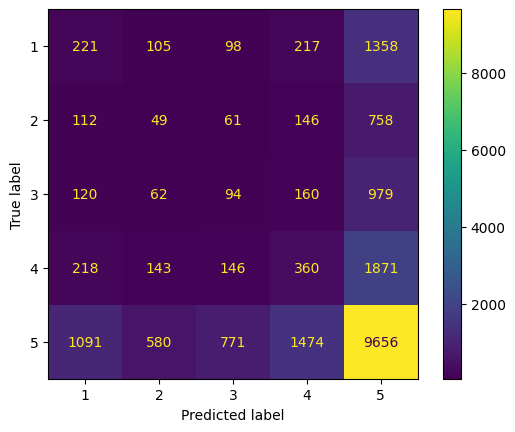

In [70]:
rf.fit(x_train, y_train)
rf_pred = rf.predict(x_test)
print(classification_report(y_pred=rf_pred, y_true=y_test))

cm = confusion_matrix(y_true=y_test, y_pred=rf_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["1", "2", "3", "4", "5"])

disp.plot()
plt.show()

652/652 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
              precision    recall  f1-score   support

         0.0       0.25      0.00      0.00      1999
         1.0       0.00      0.00      0.00      1126
         2.0       0.00      0.00      0.00      1415
         3.0       0.00      0.00      0.00      2738
         4.0       0.65      1.00      0.79     13572

    accuracy                           0.65     20850
   macro avg       0.18      0.20      0.16     20850
weighted avg       0.45      0.65      0.51     20850



c:\Users\Cyrus\anaconda3\envs\tfenv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Cyrus\anaconda3\envs\tfenv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Cyrus\anaconda3\envs\tfenv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


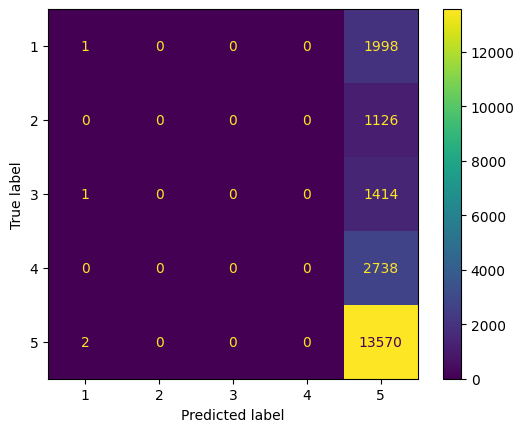

In [69]:
nn_pred = nn_class.predict(x_test)
nn_pred = [np.argmax(arr) for arr in nn_pred]
print(classification_report(y_pred=nn_pred, y_true=y_test))

cm = confusion_matrix(y_true=y_test, y_pred=nn_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["1", "2", "3", "4", "5"])

disp.plot()
plt.show()

652/652 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step
1.8264341199023693


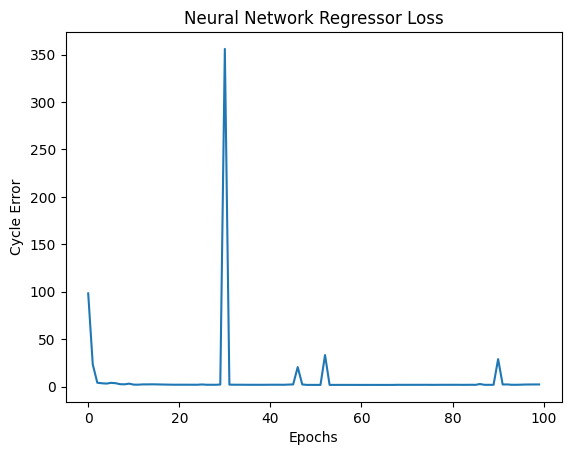

In [76]:
# Neural Network Regression MSE
nn_pred = nn_reg.predict(x_test)
print(mean_squared_error(y_true=y_test, y_pred=nn_pred))

plt.plot(reg_loss.history['loss'])
plt.title("Neural Network Regressor Loss")
plt.xlabel("Epochs")
plt.ylabel("Cycle Error")
plt.show()